In [16]:
# 导入库
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import IsolationForest
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D样式库
# 数据准备
raw_data = pd.read_csv('outlier.txt',sep=',')  # 读取数据
raw_data.shape

(10492, 47)

In [17]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10492 entries, 0 to 10491
Data columns (total 47 columns):
clientId                                10492 non-null float64
visitNumber                             10492 non-null int64
bounces                                 0 non-null float64
hits                                    10492 non-null int64
newVisits                               5800 non-null float64
pageviews                               10489 non-null float64
sessionQualityDim                       10492 non-null int64
visits                                  10492 non-null float64
adContent                               10492 non-null object
isVideoAd                               122 non-null object
campaign                                10492 non-null object
isTrueDirect                            5327 non-null object
keyword                                 10492 non-null object
medium                                  10492 non-null object
referralPath                 

In [19]:
# dropna(axis='columns',how = 'all')   axis='columns' 按列删除控制， how = 'all' 整列都为空值的情况下才删除数据
data_dropna = raw_data.dropna(axis='columns',how = 'all')

In [20]:
data_dropna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10492 entries, 0 to 10491
Data columns (total 45 columns):
clientId                                10492 non-null float64
visitNumber                             10492 non-null int64
hits                                    10492 non-null int64
newVisits                               5800 non-null float64
pageviews                               10489 non-null float64
sessionQualityDim                       10492 non-null int64
visits                                  10492 non-null float64
adContent                               10492 non-null object
isVideoAd                               122 non-null object
campaign                                10492 non-null object
isTrueDirect                            5327 non-null object
keyword                                 10492 non-null object
medium                                  10492 non-null object
referralPath                            10492 non-null object
source                    

In [23]:
# 由于异常检测 主要找到的是渠道和异常流量的关系，和具体的客户ID没关系的 所以把客户ID去掉 不作为特征
data_dropna = data_dropna.drop(['clientId'],axis=1)

In [24]:
data_dropna.shape

(10492, 44)

In [28]:
# 填充缺失值  给有缺失值的列标记为true
cols_is_na = data_dropna.isnull().any()
# 如果cols_is_na值为true 就把结果保存到na_cols
na_cols = [cols_is_na.index[ind] for ind,na_result in enumerate(cols_is_na) if na_result == True]

In [31]:
# 建立填充规则的dict
fill_rules = {'newVisits': 0, 'pageviews': 0, 'isVideoAd': False, 'isTrueDirect': False}
data_fillna = data_dropna.fillna(fill_rules)

In [32]:
data_fillna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10492 entries, 0 to 10491
Data columns (total 44 columns):
visitNumber                             10492 non-null int64
hits                                    10492 non-null int64
newVisits                               10492 non-null float64
pageviews                               10492 non-null float64
sessionQualityDim                       10492 non-null int64
visits                                  10492 non-null float64
adContent                               10492 non-null object
isVideoAd                               10492 non-null bool
campaign                                10492 non-null object
isTrueDirect                            10492 non-null bool
keyword                                 10492 non-null object
medium                                  10492 non-null object
referralPath                            10492 non-null object
source                                  10492 non-null object
socialEngagementType       

In [27]:
cols_is_na

visitNumber                             False
hits                                    False
newVisits                                True
pageviews                                True
sessionQualityDim                       False
visits                                  False
adContent                               False
isVideoAd                                True
campaign                                False
isTrueDirect                             True
keyword                                 False
medium                                  False
referralPath                            False
source                                  False
socialEngagementType                    False
channelGrouping                         False
browser                                 False
browserSize                             False
browserVersion                          False
operatingSystem                         False
operatingSystemVersion                  False
flashVersion                      

In [42]:
#拆分数值特征和字符串特征
str_or_num = (data_fillna.dtypes=='object')
str_cols = [str_or_num.index[ind] for ind,str_result in enumerate(str_or_num) if str_result == True]

In [45]:
# 字符串类型数据
string_data=data_fillna[str_cols]
num_data = data_fillna[[i for i in str_or_num.index if i not in str_cols]]

In [47]:
#分类特征转换成数值类型的类别
model_oe = OrdinalEncoder()
string_data_con = model_oe.fit_transform(string_data)

In [49]:
#处理之后的数据和本来就是非字符串类型的数据进行合并
string_data_pd = pd.DataFrame(string_data_con,columns=string_data.columns)

In [50]:
feature_merge = pd.concat((num_data,string_data_pd),axis = 1)

In [52]:
## 使用isolation forest进行异常点检测
model_isof = IsolationForest(n_estimators=20,n_jobs=1)
outlier_label = model_isof.fit_predict(feature_merge)

e:\python\ai27\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
e:\python\ai27\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
e:\python\ai27\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [54]:
outlier_pd = pd.DataFrame(outlier_label,columns=['outlier_label'])

In [55]:
data_merge = pd.concat((data_fillna,outlier_pd),axis=1)

In [56]:
outlier_count = data_merge.groupby(['outlier_label'])['visitNumber'].count()

In [57]:
outlier_count

outlier_label
-1    1050
 1    9442
Name: visitNumber, dtype: int64

In [58]:
### 统计每一个渠道的异常情况
def cal_sample(df):
    data_count = df.groupby(['source'],as_index = False)['outlier_label'].count()
    return data_count.sort_values(['outlier_label'],ascending = False)

In [59]:
outlier_source = data_merge[data_merge['outlier_label']==-1]
outlier_source_sort = cal_sample(outlier_source)

In [60]:
outlier_source_sort

,source,outlier_label
19,google,380
0,(direct),217
52,unfnshd.com,75
45,shareasale,58
55,webgains,49
10,bing,47
43,rtbhouse,38
25,linkshare,31
9,baidu,15
34,pinterest.com,10


In [61]:
normal_source = data_merge[data_merge['outlier_label']==1]
normal_source_sort = cal_sample(normal_source)

In [62]:
normal_source_sort

,source,outlier_label
31,google,4100
0,(direct),2791
89,webgains,584
73,shareasale,421
40,linkshare,390
85,unfnshd.com,264
68,rtbhouse,180
10,bing,150
24,ebay,99
60,pinterest.com,61


In [63]:
### 数据合并
source_merge = pd.merge(outlier_source_sort,normal_source_sort,on='source',how='outer')

In [65]:
source_merge = source_merge.fillna(0)

In [67]:
source_merge.columns

Index(['source', 'outlier_label_x', 'outlier_label_y'], dtype='object')

In [68]:
source_merge = source_merge.rename(index=str, columns={'outlier_label_x':'outlier_count','outlier_label_y':'normal_count'})

In [69]:
source_merge['total_count'] = source_merge['outlier_count']+source_merge['normal_count']
source_merge['outlier_rate'] = source_merge['outlier_count']/(source_merge['total_count'])

In [70]:
source_merge

,source,outlier_count,normal_count,total_count,outlier_rate
0,google,380.0,4100.0,4480.0,0.084821
1,(direct),217.0,2791.0,3008.0,0.072141
2,unfnshd.com,75.0,264.0,339.0,0.221239
3,shareasale,58.0,421.0,479.0,0.121086
4,webgains,49.0,584.0,633.0,0.077409
5,bing,47.0,150.0,197.0,0.238579
6,rtbhouse,38.0,180.0,218.0,0.174312
7,linkshare,31.0,390.0,421.0,0.073634
8,baidu,15.0,19.0,34.0,0.441176
9,pinterest.com,10.0,61.0,71.0,0.140845


Text(0.5, 0.92, 'outlier point distribution')

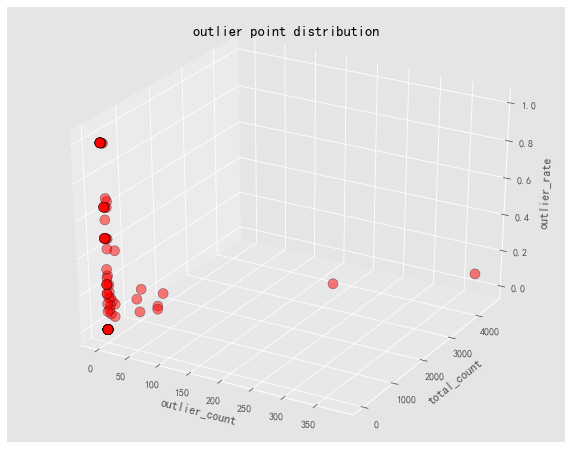

In [71]:
# 异常点图形展示
plt.style.use('ggplot')  # 使用ggplot样式库
fig = plt.figure(figsize=(10, 8))  # 创建画布对象
# 画图  1行1列在第一个位置上  projection 3d 画三维的图
ax = fig.add_subplot(111, projection='3d')
# 前三个值 三维图像 x,y,z 对应的值   s=点大小 edgecolors='边缘颜色', c='点的颜色', marker='点样式',alpha=透明度
ax.scatter(source_merge['outlier_count'], source_merge['total_count'], source_merge['outlier_rate'],
           s=100, edgecolors='k', c='r', marker='o',alpha=0.5) 
# x，y z 坐标轴起名
ax.set_xlabel('outlier_count')
ax.set_ylabel('total_count')
ax.set_zlabel('outlier_rate')
plt.title('outlier point distribution')  # 设置图像标题

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\beibei\AppData\Local\Temp\jieba.cache
Loading model cost 1.073 seconds.
Prefix dict has been built succesfully.


数据 113
分析 48
功能 47
Adobe 45
Analytics 37


(-0.5, 509.5, 516.5, -0.5)

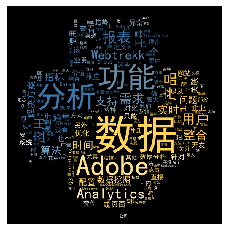

In [72]:
import re  # 正则表达式库
import collections  # 词频统计库
import numpy as np  # numpy库
import jieba  # 结巴分词
import wordcloud  # 词云展示库
from PIL import Image  # 图像处理库
import matplotlib.pyplot as plt  # 图像展示库
# 读取文本文件
with open('article1.txt') as fn:
    string_data = fn.read()  # 使用read方法读取整段文本
# 文本预处理
pattern = re.compile(u'\t|\n|\.|-|一|:|;|\)|\(|\?|"')  # 建立正则表达式匹配模式
string_data = re.sub(pattern, '', string_data)  # 将符合模式的字符串替换掉
# 文本分词
seg_list_exact = jieba.cut(string_data, cut_all=False)  # 精确模式分词[默认模式]
remove_words = ['的', '，', '和', '是', '随着', '对于', ' ', '对', '等', '能', '都', '。', '、', '中', '与', '在', '其', '了', '可以', '进行', '有', '更', '需要', '提供', '多', '能力', '通过', '会', '不同', '一个', '这个', '我们', '将', '并', '同时', '看', '如果', '但', '到', '非常', '—', '如何', '包括', '这']  # 自定义去除词库
# remove_words = [] #空去除词列表，用于跟关键字提取做效果对比
object_list = [i for i in seg_list_exact if i not in remove_words] # 将不在去除词列表中的词添加到列表中
# 词频统计
word_counts = collections.Counter(object_list)  # 对分词做词频统计
word_counts_top5 = word_counts.most_common(5)  # 获取前5个频率最高的词
for w, c in word_counts_top5:  # 分别读出每条词和出现从次数
    print(w, c)  # 打印输出
# 词频展示
mask = np.array(Image.open('wordcloud.jpg'))  # 定义词频背景
wc = wordcloud.WordCloud(
    font_path='C:/Windows/Fonts/simhei.ttf',  # 设置字体格式，不设置将无法显示中文
    mask=mask,  # 设置背景图
    max_words=200,  # 设置最大显示的词数
    max_font_size=100,  # 设置字体最大值
   
)
wc.generate_from_frequencies(word_counts)  # 从字典生成词云
image_colors = wordcloud.ImageColorGenerator(mask)  # 从背景图建立颜色方案
wc.recolor(color_func=image_colors)  # 将词云颜色设置为背景图方案
plt.imshow(wc)  # 显示词云
plt.axis('off')  # 关闭坐标轴

In [73]:
import jieba.posseg as pseg
import pandas as pd
with open('article1.txt') as fn:
    string_data = fn.read()  # 使用read方法读取整段文本
# 分词+词性标注
words = pseg.cut(string_data)  # 分词

In [75]:
list(words)

[pair('Adobe', 'eng'),
 pair(' ', 'x'),
 pair('Analytics', 'eng'),
 pair('和', 'c'),
 pair('Webtrekk', 'eng'),
 pair('都', 'd'),
 pair('是', 'v'),
 pair('在线', 'b'),
 pair('数据分析', 'l'),
 pair('领域', 'n'),
 pair('的', 'uj'),
 pair('巨擘', 'n'),
 pair('，', 'x'),
 pair('一个', 'm'),
 pair('是', 'v'),
 pair('美国市场', 'nt'),
 pair('第一', 'm'),
 pair('，', 'x'),
 pair('一个', 'm'),
 pair('欧洲', 'ns'),
 pair('市场', 'n'),
 pair('第一', 'm'),
 pair('，', 'x'),
 pair('都', 'd'),
 pair('能', 'v'),
 pair('提供', 'v'),
 pair('世界', 'n'),
 pair('一流', 'n'),
 pair('的', 'uj'),
 pair('数字', 'n'),
 pair('分析', 'vn'),
 pair('解决方案', 'n'),
 pair('。', 'x'),
 pair('我', 'r'),
 pair('很', 'd'),
 pair('有幸', 'a'),
 pair('能', 'v'),
 pair('有', 'v'),
 pair('机会', 'n'),
 pair('深入', 'v'),
 pair('了解', 'v'),
 pair('并', 'c'),
 pair('应用', 'v'),
 pair('这', 'r'),
 pair('两种', 'm'),
 pair('解决方案', 'n'),
 pair('，', 'x'),
 pair('同时', 'c'),
 pair('也', 'd'),
 pair('深感', 'a'),
 pair('数字', 'n'),
 pair('分析', 'vn'),
 pair('领域', 'n'),
 pair('永远', 'd'),
 pair('不', 'd

In [92]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

In [93]:
X

[[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]

In [94]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target
X.shape

(150, 4)

In [97]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [95]:
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

(150, 2)

In [108]:
temp = pd.concat([pd.DataFrame(X),pd.Series(y)],axis  =1)
temp.columns = ['1','2','3','4','y']

In [110]:
temp.corr()

,1,2,3,4,y
1,1.000000,-0.117570,0.871754,0.817941,0.782561
2,-0.117570,1.000000,-0.428440,-0.366126,-0.426658
3,0.871754,-0.428440,1.000000,0.962865,0.949035
4,0.817941,-0.366126,0.962865,1.000000,0.956547
y,0.782561,-0.426658,0.949035,0.956547,1.000000


In [113]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

rf = RandomForestClassifier()
iris=load_iris()
X,y=iris.data,iris.target
rfe = RFE(estimator=rf, n_features_to_select=1)
X_rfe = rfe.fit_transform(X,y)
X_rfe.shape

e:\python\ai27\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
e:\python\ai27\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
e:\python\ai27\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
e:\python\ai27\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(150, 1)

In [114]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X,y)
model = SelectFromModel(lsvc, prefit=True)
X_embed = model.transform(X)
X_embed.shape

e:\python\ai27\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(150, 3)

In [115]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,label,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [117]:
#针对fare分成10箱
df_train.loc[:,'fare_qcut'] = pd.qcut(df_train['Fare'], 10)

df_train.head()
#对数据进行排序 目的是按照Fare从小到大顺序取出 Fare所对应的标签
df_train = df_train.sort_values('Fare')
alist = list(set(df_train['fare_qcut']))

In [119]:
badrate = {}
for x in alist:
    # 遍历所有组数据 
    a = df_train[df_train.fare_qcut == x]
    # 取出一组 计算标签为1 的数据条数
    bad = a[a.label == 1]['label'].count()
     # 取出一组 计算标签为0 的数据条数
    good = a[a.label == 0]['label'].count()
    # 计算当前这一组是1的概率
    badrate[x] = bad/(bad+good)

In [120]:
badrate

{Interval(8.05, 10.5, closed='right'): 0.23076923076923078,
 Interval(7.55, 7.854, closed='right'): 0.2988505747126437,
 Interval(39.688, 77.958, closed='right'): 0.5280898876404494,
 Interval(14.454, 21.679, closed='right'): 0.42045454545454547,
 Interval(-0.001, 7.55, closed='right'): 0.14130434782608695,
 Interval(10.5, 14.454, closed='right'): 0.42857142857142855,
 Interval(77.958, 512.329, closed='right'): 0.7586206896551724,
 Interval(21.679, 27.0, closed='right'): 0.5168539325842697,
 Interval(27.0, 39.688, closed='right'): 0.37362637362637363,
 Interval(7.854, 8.05, closed='right'): 0.1792452830188679}

                 cut   badrate
9     (-0.001, 7.55]  0.141304
6      (7.55, 7.854]  0.298851
8      (7.854, 8.05]  0.179245
7       (8.05, 10.5]  0.230769
3     (10.5, 14.454]  0.428571
4   (14.454, 21.679]  0.420455
2     (21.679, 27.0]  0.516854
5     (27.0, 39.688]  0.373626
1   (39.688, 77.958]  0.528090
0  (77.958, 512.329]  0.758621


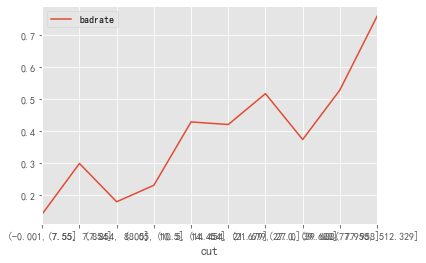

In [121]:
f = zip(badrate.keys(),badrate.values())
f = sorted(f,key = lambda x : x[1],reverse = True )
badrate = pd.DataFrame(f)
badrate.columns = pd.Series(['cut','badrate'])
badrate = badrate.sort_values('cut')
print(badrate)
badrate.plot('cut','badrate')

In [122]:
def binn(x):
    if x<10.5:
        return 0
    elif x<39.688:
        return 1
    else:
        return 2
df_train['fare_cut_new'] = df_train.Fare.map(lambda x:binn(x))

   cut   badrate
2    0  0.197640
1    1  0.430851
0    2  0.642045


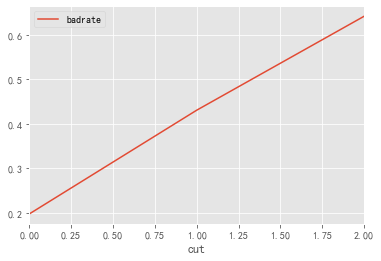

In [123]:
df_train = df_train.sort_values('Fare')
alist = list(set(df_train['fare_cut_new']))
badrate = {}
for x in alist:
    
    a = df_train[df_train.fare_cut_new == x]
    
    bad = a[a.label == 1]['label'].count()
    good = a[a.label == 0]['label'].count()
    
    badrate[x] = bad/(bad+good)
f = zip(badrate.keys(),badrate.values())
f = sorted(f,key = lambda x : x[1],reverse = True )
badrate = pd.DataFrame(f)
badrate.columns = pd.Series(['cut','badrate'])
badrate = badrate.sort_values('cut')
print(badrate)
badrate.plot('cut','badrate')

### 案例  决策树做特征筛选

In [124]:
import pandas as pd
import numpy as np
data = pd.read_excel('oil_data_for_tree.xlsx')
data.head()

,uid,oil_actv_dt,create_dt,total_oil_cnt,pay_amount_total,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
0,A8217710,2018-08-19,2018-08-17,275.0,48295495.4,B,0,3308.56,1760081.0,1796001.0,1731081.0,8655401.0,1.0,1.0,1,3,2,0,3
1,A8217710,2018-08-19,2018-08-16,275.0,48295495.4,B,0,4674.68,2487045.0,2537801.0,2437845.0,12189221.0,1.0,1.0,1,3,2,0,3
2,A8217710,2018-08-19,2018-08-15,275.0,48295495.4,B,0,1873.06,977845.0,997801.0,961845.0,4809221.0,1.0,1.0,1,2,2,0,3
3,A8217710,2018-08-19,2018-08-14,275.0,48295495.4,B,0,4837.78,2526441.0,2578001.0,2484441.0,12422201.0,1.0,1.0,1,2,2,0,3
4,A8217710,2018-08-19,2018-08-13,275.0,48295495.4,B,0,2586.38,1350441.0,1378001.0,1328441.0,6642201.0,1.0,1.0,1,2,2,0,3


In [125]:
set(data.class_new)

{'A', 'B', 'C', 'D', 'E', 'F'}

In [126]:
#不需要改动 直接使用原始特征 的列
org_lst = ['uid','create_dt','oil_actv_dt','class_new','bad_ind']
# 可以使用统计值做衍生特征的列
agg_lst = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
# 可以使用数条数 来做衍生特征的列
dstc_lst = ['channel_code','oil_code','scene','source_app','call_source']

In [127]:
df = data[org_lst].copy()
df[agg_lst] = data[agg_lst].copy()
df[dstc_lst] = data[dstc_lst].copy()

In [128]:
df.isna().sum()

uid                         0
create_dt                4944
oil_actv_dt                 0
class_new                   0
bad_ind                     0
oil_amount               4944
discount_amount          4944
sale_amount              4944
amount                   4944
pay_amount               4944
coupon_amount            4944
payment_coupon_amount    4946
channel_code                0
oil_code                    0
scene                       0
source_app                  0
call_source                 0
dtype: int64

In [129]:
df.describe()

,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
count,50609.000000,45665.000000,4.566500e+04,4.566500e+04,4.566500e+04,4.566500e+04,45665.000000,45663.000000,50609.000000,50609.000000,50609.000000,50609.000000,50609.000000
mean,0.017764,425.376107,1.832017e+05,1.881283e+05,1.808673e+05,9.043344e+05,0.576853,149.395397,1.476378,1.617894,1.906519,0.306072,2.900729
std,0.132093,400.596244,2.007574e+05,2.048742e+05,1.977035e+05,9.885168e+05,0.494064,605.138823,1.511470,3.074166,0.367280,0.893682,0.726231
min,0.000000,1.000000,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,175.440000,6.039100e+04,6.200100e+04,5.976100e+04,2.988010e+05,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
50%,0.000000,336.160000,1.229310e+05,1.279240e+05,1.209610e+05,6.048010e+05,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
75%,0.000000,557.600000,2.399050e+05,2.454010e+05,2.360790e+05,1.180391e+06,1.000000,100.000000,1.000000,0.000000,2.000000,0.000000,3.000000
max,1.000000,7952.820000,3.916081e+06,3.996001e+06,3.851081e+06,1.925540e+07,1.000000,50000.000000,6.000000,9.000000,2.000000,3.000000,4.000000


In [ ]:
#对creat_dt做补全，用oil_actv_dt来填补
#截取6个月的数据。  
#构造变量的时候不能直接对历史所有数据做累加。  
#否则随着时间推移，变量分布会有很大的变化。

In [130]:
def time_isna(x,y):
    if str(x) == 'NaT':
        x = y
    else:
        x = x
    return x
df2 = df.sort_values(['uid','create_dt'],ascending = False)
df2['create_dt'] = df2.apply(lambda x: time_isna(x.create_dt,x.oil_actv_dt),axis = 1)
df2['dtn'] = (df2.oil_actv_dt - df2.create_dt).apply(lambda x :x.days)
df = df2[df2['dtn']<180]
df.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source,dtn
50608,B96436391985035703,2018-10-08,2018-10-08,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50607,B96436391984693397,2018-10-11,2018-10-11,E,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50606,B96436391977217468,2018-10-17,2018-10-17,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50605,B96436391976480892,2018-09-28,2018-09-28,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50604,B96436391972106043,2018-10-19,2018-10-19,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45039 entries, 50608 to 45296
Data columns (total 18 columns):
uid                      45039 non-null object
create_dt                45039 non-null datetime64[ns]
oil_actv_dt              45039 non-null datetime64[ns]
class_new                45039 non-null object
bad_ind                  45039 non-null int64
oil_amount               40095 non-null float64
discount_amount          40095 non-null float64
sale_amount              40095 non-null float64
amount                   40095 non-null float64
pay_amount               40095 non-null float64
coupon_amount            40095 non-null float64
payment_coupon_amount    40093 non-null float64
channel_code             45039 non-null int64
oil_code                 45039 non-null int64
scene                    45039 non-null int64
source_app               45039 non-null int64
call_source              45039 non-null int64
dtn                      45039 non-null int64
dtypes: datetime64[ns](2)

In [132]:
base = df[org_lst]
base['dtn'] = df['dtn']
base = base.sort_values(['uid','create_dt'],ascending = False)
# drop_duplicates  删除重复的  根据'uid'判断重复值  ,keep = 'first' 只保留第一条
base = base.drop_duplicates(['uid'],keep = 'first')
base.shape  

e:\python\ai27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(11099, 6)

In [133]:
### 特征衍生
### agg_lst = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
gn = pd.DataFrame()
for i in agg_lst:
    #根据用户的uid分组，统计同一个用户在数据中有几条记录， 实际上就是统计贷款的次数
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:len(df[i])).reset_index())
    tp.columns = ['uid',i + '_cnt']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.where(df[i]>0,1,0).sum()).reset_index())
    tp.columns = ['uid',i + '_num']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nansum(df[i])).reset_index())
    tp.columns = ['uid',i + '_tot']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index())
    tp.columns = ['uid',i + '_avg']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index())
    tp.columns = ['uid',i + '_max']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index())
    tp.columns = ['uid',i + '_min']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index())
    tp.columns = ['uid',i + '_var']
    if gn.empty == True:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

e:\python\ai27\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
e:\python\ai27\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: All-NaN axis encountered
e:\python\ai27\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: All-NaN axis encountered
e:\python\ai27\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice.
e:\python\ai27\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: All-NaN axis encountered


In [135]:
gc = pd.DataFrame()
# 针对用户进行分组，看看每一个用户在这些分类类型的变量中，有几条不同分类的记录，也可以用作衍生特征
for i in dstc_lst:
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df: len(set(df[i]))).reset_index())
    tp.columns = ['uid',i + '_dstc']
    if gc.empty == True:
        gc = tp
    else:
        gc = pd.merge(gc,tp,on = 'uid',how = 'left')

In [ ]:
#dstc_lst = ['channel_code','oil_code','scene','source_app','call_source']

In [136]:
fn = pd.merge(base,gn,on= 'uid')
fn = pd.merge(fn,gc,on= 'uid') 
fn.shape

(11099, 67)

In [137]:
data.shape

(50609, 19)

In [140]:
fn = fn.fillna(0)

In [141]:
x = fn.drop(['uid','oil_actv_dt','create_dt','bad_ind','class_new'],axis = 1)
y = fn.bad_ind.copy()
from sklearn import tree

dtree = tree.DecisionTreeRegressor(max_depth = 2,min_samples_leaf = 500,min_samples_split = 5000)
dtree = dtree.fit(x,y)

e:\python\ai27\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


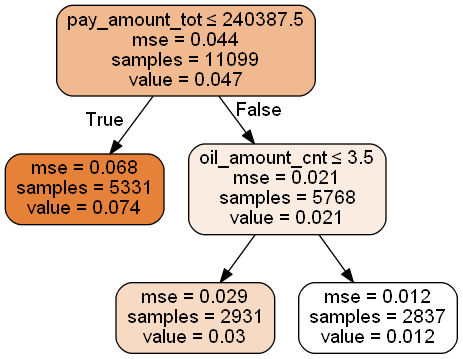

In [142]:
import pydotplus 
from IPython.display import Image
from sklearn.externals.six import StringIO
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
with open("dt.dot", "w") as f:
    tree.export_graphviz(dtree, out_file=f)
dot_data = StringIO()
tree.export_graphviz(dtree, out_file=dot_data,
                         feature_names=x.columns,
                         class_names=['bad_ind'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [143]:
sum(fn.bad_ind)/len(fn.bad_ind)

0.04658077304261645